In [49]:
import tensorflow as tf
import tf_util
import numpy as np
import pickle
import os
import time
from matplotlib import pyplot as plt
import gym
import random
import mujoco_py
import load_policy

%load_ext autoreload
%autoreload 2

def set_seed(seed_number):
    os.environ['PYTHONHASHSEED']=str(seed_number)
    random.seed(seed_number)
    np.random.seed(seed_number)
    tf.set_random_seed(seed_number)
    
def split_data(data):
    x, y = data['observations'], data['actions']
    n = x.shape[0]
    arr = np.arange(n)
    np.random.shuffle(arr)
    x, y = data['observations'][arr], data['actions'][arr]
    x_train, y_train = x[:int(0.6*n)], y[:int(0.6*n)]
    x_val, y_val = x[int(0.6*n):int(0.8*n)], y[int(0.6*n):int(0.8*n)]
    x_test, y_test = x[int(0.8*n):], y[int(0.8*n):]
    return x_train, y_train, x_val, y_val, x_test, y_test

def get_session(): # use with get_session() as sess: or sess = get_session()
    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Game Env

In [55]:
# take a look at the dimension of state and action in each game environment
env_name = ['Ant-v2', 'HalfCheetah-v2', 'Hopper-v2', 'Humanoid-v2', 'Reacher-v2', 'Walker2d-v2']
for game in env_name:
    env = gym.make(game)
    s = env.reset()
    print(game, s.shape, env.action_space) #env.action_space.sample()
    print(env.action_space.sample())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Ant-v2 (111,) Box(8,)
[ 0.38506317  0.45050856  0.00264876  0.91216725  0.2879804  -0.1522899
  0.21278642 -0.9616136 ]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
HalfCheetah-v2 (17,) Box(6,)
[-0.39685038  0.32034707 -0.41984478  0.23603086 -0.1424626  -0.7290519 ]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Hopper-v2 (11,) Box(3,)
[-0.40343535  0.13992982  0.18174553]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box a

# Behavior cloning

#### 0. setup function

In [57]:
def load_split_data(data, game):
    # load experts data
    with open('./expert_data/'+str(data)+'.pkl', 'rb') as handle:
        human = pickle.load(handle)
    #print('observation', human['observations'].shape)
    #print('action', human['actions'].shape)
    #print()
    #print('observation example \n', human['observations'][0])
    #print('action example \n', human['actions'][0])
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(human)
    
    env = gym.make(game)
    num_action = len(env.action_space.sample())
    num_state = env.reset().shape[0]
    return x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state

In [58]:
# define mlp nets
def model(state_dim, action_dim):
    state = tf.placeholder(tf.float32, [None, state_dim])
    action = tf.placeholder(tf.float32, [None, 1, action_dim])
    if state_dim > 100:
        with tf.variable_scope('fc'):
            fc1 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 1024))
            fc2 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc1, 1024))
            fc3 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc2, 512))
            fc4 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc3, 256))
            out = tf.contrib.layers.fully_connected(fc4, action_dim, activation_fn=None)   
    else:
        with tf.variable_scope('fc'):
            fc1 = tf.contrib.layers.fully_connected(state, 1024)
            out = tf.contrib.layers.fully_connected(fc1, action_dim, activation_fn=None)           
    
    out = tf.reshape(out, [tf.shape(state)[0], 1, action_dim])
    return state, action, out

def loss_function(pred, label):
    loss = tf.losses.mean_squared_error(pred, label)
    return loss

def optimizer(loss, lr = 1e-4):
    train_step = tf.train.AdamOptimizer(lr, epsilon=1e-4).minimize(loss)
    return train_step

In [4]:
# train nn
def train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, 
             epoch, x_train, y_train, x_val, y_val, x_test, y_test, plot = True, lr = None, verbose = True):
    set_seed(1)
    
    state, action, out = model(num_state, num_action)
    mean_loss = loss_function(out, action)
    train_step = optimizer(mean_loss)
    
    var= tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    sess.run(tf.global_variables_initializer())    
    
    for i in range(epoch):
        loss_his, loss_his2, loss_his3 = [], [], []
        for j in range(int(x_train.shape[0]/batch_size)):
            _, loss_train = sess.run([train_step, mean_loss], feed_dict={state:x_train[j*batch_size:(j+1)*batch_size]
                                                                                , action:y_train[j*batch_size:(j+1)*batch_size]})
            loss_his.append(loss_train)
        
            loss_val = sess.run([mean_loss], feed_dict={state:x_val[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_val[j*batch_size2:(j+1)*batch_size2]})
            loss_test = sess.run([mean_loss], feed_dict={state:x_test[j*batch_size2:(j+1)*batch_size2]
                                                                                , action:y_test[j*batch_size2:(j+1)*batch_size2]})
            loss_his2.append(loss_val)
            loss_his3.append(loss_test)
        
        if verbose:
            print('\n'+str(i)+' epoch: '+'train loss', loss_train)
            print('val loss: '+ str(np.mean(np.array(loss_his2)))+' test loss: ',str(np.mean(np.array(loss_his3))) )
        if plot and i % 10 == 0:
            plt.plot(loss_his)
            plt.title('Loss train')
            plt.show()
            
    return sess, state, action, out

In [5]:
# evaluate policy of trained agent
def eval_policy(game, num_rollouts, sess, state, out, env, verbose = True, render = False, data_gen = False):
    returns = []
    
    for i in range(num_rollouts):
        steps = 0
        obs = env.reset()
        if i == 0 and data_gen:
            data_pi = obs.reshape(1, -1)
        done = False
        totalr = 0

        while not done:
            action = sess.run(out, feed_dict={state:obs.reshape(1, -1)})
            obs, r, done, _ = env.step(action)
            if data_gen:
                data_pi = np.concatenate([data_pi, obs.reshape(1,-1)])
            totalr += r
            steps += 1
            if render:
                env.render()
        returns.append(totalr)
        if verbose:
            print('\niter', i)
            print('mean return', np.mean(returns))
            print('std of return', np.std(returns))
        else:
            if i == num_rollouts-1:
                print('mean return', np.mean(returns))
                print('std of return', np.std(returns))
    
    if data_gen:
        return returns, data_pi
    else:
        return returns

#### 1. HalfCheetah

observation (100000, 17)
action (100000, 1, 6)

observation example 
 [-0.02033121  0.06750765 -0.0578007  -0.07536742 -0.06343042 -0.02833271
 -0.02037377 -0.06787478  0.00838537  0.10618275  0.1457029  -0.17950187
  0.096978   -0.1579786  -0.08390649 -0.06582695  0.03371656]
action example 
 [[ 0.05203422  0.61691374 -0.9345577   0.7927394   0.2631963   0.10855416]]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.048844807
val loss: 0.11015327 test loss:  0.9969691


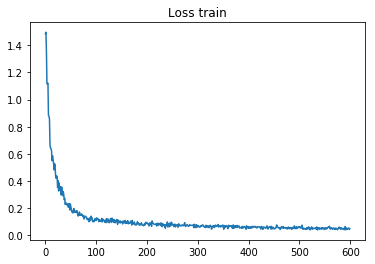


1 epoch: train loss 0.03186901
val loss: 0.038897507 test loss:  1.0486764

2 epoch: train loss 0.025142366
val loss: 0.028347753 test loss:  1.0624768

3 epoch: train loss 0.02138446
val loss: 0.02308547 test loss:  1.0702846

4 epoch: train loss 0.018909222
val loss: 0.019827003 test loss:  1.07529

5 epoch: train loss 0.017117556
val loss: 0.017496862 test loss:  1.0787938

6 epoch: train loss 0.015694983
val loss: 0.015711939 test loss:  1.0814825

7 epoch: train loss 0.014427667
val loss: 0.014290466 test loss:  1.0834967

8 epoch: train loss 0.013330912
val loss: 0.0131365955 test loss:  1.0851756

9 epoch: train loss 0.01237272
val loss: 0.012177383 test loss:  1.0866277

10 epoch: train loss 0.011585579
val loss: 0.011369458 test loss:  1.0878508


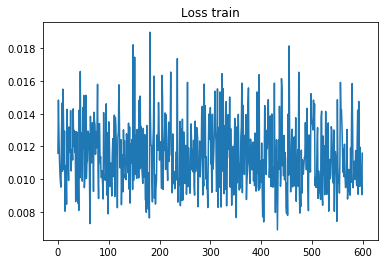


11 epoch: train loss 0.010909028
val loss: 0.010680187 test loss:  1.0889237

12 epoch: train loss 0.010319751
val loss: 0.010083873 test loss:  1.089857

13 epoch: train loss 0.009791179
val loss: 0.009565881 test loss:  1.0907073

14 epoch: train loss 0.009372994
val loss: 0.009107452 test loss:  1.0914204

15 epoch: train loss 0.008964133
val loss: 0.008700065 test loss:  1.0920506

16 epoch: train loss 0.008556507
val loss: 0.008338826 test loss:  1.0926269

17 epoch: train loss 0.008224463
val loss: 0.008012897 test loss:  1.0931394

18 epoch: train loss 0.007922079
val loss: 0.007717022 test loss:  1.0935924

19 epoch: train loss 0.0076276376
val loss: 0.00744702 test loss:  1.0939962

20 epoch: train loss 0.0073460652
val loss: 0.007200303 test loss:  1.0943619


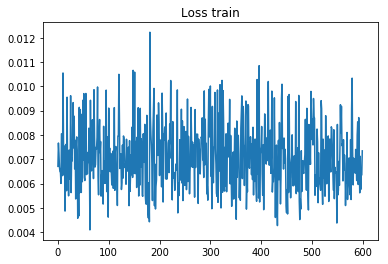


21 epoch: train loss 0.007048464
val loss: 0.0069723097 test loss:  1.0946891

22 epoch: train loss 0.00680396
val loss: 0.0067605623 test loss:  1.0949808

23 epoch: train loss 0.0065852827
val loss: 0.006564352 test loss:  1.0952562

24 epoch: train loss 0.006371486
val loss: 0.0063825045 test loss:  1.0955119
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [20]:
# split data, create env
data = 'HalfCheetah-v22'
game = 'HalfCheetah-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# evaluate policy of trained agent
env = gym.make(game)
num_rollouts = 100
returns = []
returns = eval_policy(game, num_rollouts, sess, state, out)

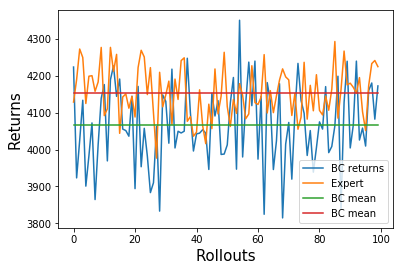

<Figure size 432x288 with 0 Axes>

In [22]:
# plot returns of BC and experts
plt.plot(returns, label = 'BC returns')
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [4128.728383502425, 4189.535684673227, 4272.43303667612, 4249.560423016207, 4124.772769049202, 4198.7097924364125, 4200.1419735573745, 4157.776701879373, 4183.002617459517, 4276.806235453813, 4091.9185494035255, 4110.495515510108, 4276.9212743364515, 4211.965179413419, 4257.969935553734, 4043.885796969095, 4142.499163256315, 4150.679691581168, 4112.035436378099, 4144.082152181334, 4088.0712633445924, 4222.320207777014, 4269.064293269311, 4250.906939027812, 4148.951248388147, 4222.023925064402, 4098.925831355091, 3976.6875579460834, 4209.380638842714, 4115.734884418981, 4147.831670044442, 4185.394716315659, 4067.801853424089, 4190.939196720014, 4135.750687511855, 4241.12220146413, 4248.600645493026, 4076.5123996714224, 4089.116529174026, 4036.020140445872, 4047.0686695754534, 4161.7820300860285, 4064.3324558793024, 4015.9265603773433, 4122.9001866605395, 4056.6786930649814, 4218.364321840599, 4096.500474489058, 4144.684147770466, 4263.584984166652, 4116.606466006029, 4062.521071746634, 4135.656341300057, 4097.933123609351, 4178.558245317028, 4146.867606323324, 4083.399670997339, 4096.388304382819, 4227.133001891338, 4127.106261158067, 4122.227998151923, 4141.7516718342695, 4257.282575178695, 4099.169477649469, 4159.645790167006, 4099.959176133804, 4145.190574195959, 4188.549485786253, 4218.614841959601, 4196.916768206129, 4188.857668924531, 4092.3066926686647, 4152.206825351386, 4054.9296687822607, 4087.5672154644267, 4236.416859209656, 4082.4200891082974, 4174.03411470297, 4104.986535282874, 4202.833953389136, 4106.019843779324, 4093.815304044671, 4145.191533113684, 4106.467003824522, 4163.7244443784775, 4292.848002944813, 4085.0320479459824, 4161.563694890181, 4266.924476517376, 4175.447192583615, 4179.846330812467, 4168.484682905271, 4152.822904171786, 4194.979992335082, 4102.46226750325, 4051.3197245830893, 4173.358193314855, 4232.962184045349, 4241.348806201747, 4224.688252340227]
plt.plot(expert,label = 'Expert')
plt.plot(np.mean(returns)*np.ones((100,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((100,)), label = 'BC mean')
plt.legend()
plt.figure()
plt.show()

In [34]:
# performance w.r.t learning rate

# split data, create env
data = 'HalfCheetah-v22'
game = 'HalfCheetah-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
lr_list = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
return_list = []
for i in lr_list:
    sess = get_session()
    sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train,
                                        y_train, x_val, y_val, x_test, y_test, lr = i, plot = False, verbose = False)

    # evaluate policy of trained agent
    env = gym.make(game)
    num_rollouts = 25
    returns = []
    returns = eval_policy(game, num_rollouts, sess, state, out, verbose = False)
    return_list.append(returns)

observation (100000, 17)
action (100000, 1, 6)

observation example 
 [-0.02033121  0.06750765 -0.0578007  -0.07536742 -0.06343042 -0.02833271
 -0.02037377 -0.06787478  0.00838537  0.10618275  0.1457029  -0.17950187
  0.096978   -0.1579786  -0.08390649 -0.06582695  0.03371656]
action example 
 [[ 0.05203422  0.61691374 -0.9345577   0.7927394   0.2631963   0.10855416]]
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.048844803
val loss: 0.11015327 test loss:  0.996969

1 epoch: train loss 0.03186901
val loss: 0.038897507 test loss:  1.0486764

2 epoch: train loss 0.02514236
val loss: 0.028347747 test loss:  1.0624768

3 epoch: train loss 0.021391824
val loss: 0.023085736 test loss:  1.0702851

4 epoch: train loss 0.018910933
val loss: 0.019827193 test loss:  1.0752928

5 epoch: train loss 0.017104033
val loss: 0.01749


5 epoch: train loss 0.017117452
val loss: 0.017496223 test loss:  1.078794

6 epoch: train loss 0.015689442
val loss: 0.015712267 test loss:  1.0814809

7 epoch: train loss 0.014425494
val loss: 0.014290081 test loss:  1.0834992

8 epoch: train loss 0.013329611
val loss: 0.013137406 test loss:  1.0851763

9 epoch: train loss 0.012374604
val loss: 0.012179365 test loss:  1.0866328

10 epoch: train loss 0.011575622
val loss: 0.011372047 test loss:  1.0878524

11 epoch: train loss 0.010901316
val loss: 0.010682818 test loss:  1.0889193

12 epoch: train loss 0.010315658
val loss: 0.010086242 test loss:  1.0898527

13 epoch: train loss 0.009780888
val loss: 0.00956828 test loss:  1.090705

14 epoch: train loss 0.009358102
val loss: 0.009108718 test loss:  1.0914214

15 epoch: train loss 0.008945072
val loss: 0.008701352 test loss:  1.0920546

16 epoch: train loss 0.008556118
val loss: 0.008339734 test loss:  1.0926191

17 epoch: train loss 0.00821153
val loss: 0.008013638 test loss:  1.093

In [36]:
# print mean and std of return of 25 number of simulations
for i in return_list:
    print(np.mean(i), np.std(i))

4042.3781129026493 135.58652892792512
4035.862748085297 122.70289985368629
4064.313364289852 86.37894634894374
4049.7833811827113 104.68512829328776
4045.765394144802 114.08333693152503


#### 2. Humanoid-v2

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.68529475
val loss: 1.2500179 test loss:  1.2235687


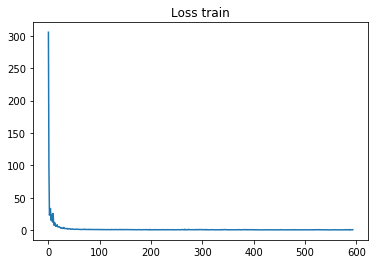


1 epoch: train loss 0.55952054
val loss: 0.3474591 test loss:  0.3425693

2 epoch: train loss 0.41780123
val loss: 0.30663595 test loss:  0.30498746

3 epoch: train loss 0.20279482
val loss: 0.26899123 test loss:  0.26945522

4 epoch: train loss 0.2946487
val loss: 0.17546363 test loss:  0.17419583

5 epoch: train loss 0.31809944
val loss: 0.16608052 test loss:  0.16526447

6 epoch: train loss 0.23697689
val loss: 0.16375168 test loss:  0.16044234

7 epoch: train loss 0.13073877
val loss: 0.14259027 test loss:  0.1392124

8 epoch: train loss 0.15649703
val loss: 0.12524287 test loss:  0.12446427

9 epoch: train loss 0.10683251
val loss: 0.11574864 test loss:  0.11473163

10 epoch: train loss 0.10916003
val loss: 0.108521 test loss:  0.10958725


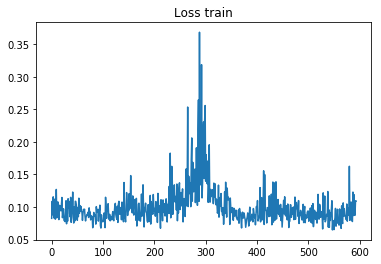


11 epoch: train loss 0.10018793
val loss: 0.09332396 test loss:  0.094131395

12 epoch: train loss 0.09816004
val loss: 0.0920828 test loss:  0.092388265

13 epoch: train loss 0.083559096
val loss: 0.088949546 test loss:  0.08945842

14 epoch: train loss 0.084279545
val loss: 0.08259385 test loss:  0.08334948

15 epoch: train loss 0.07860647
val loss: 0.07993852 test loss:  0.080374286

16 epoch: train loss 0.070658274
val loss: 0.07663055 test loss:  0.07690693

17 epoch: train loss 0.06366991
val loss: 0.0738572 test loss:  0.0740254

18 epoch: train loss 0.06688006
val loss: 0.07015665 test loss:  0.07046808

19 epoch: train loss 0.05817153
val loss: 0.0681103 test loss:  0.06809122

20 epoch: train loss 0.058969874
val loss: 0.06564179 test loss:  0.06567344


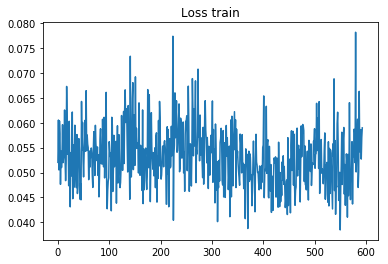


21 epoch: train loss 0.051900227
val loss: 0.063658275 test loss:  0.06354195

22 epoch: train loss 0.053281844
val loss: 0.06155551 test loss:  0.06170892

23 epoch: train loss 0.048481278
val loss: 0.05960462 test loss:  0.059742436

24 epoch: train loss 0.047456868
val loss: 0.05848527 test loss:  0.058487248
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

iter 0
mean return 992.8510480929162
std of return 0.0

iter 1
mean return 716.5783120404137
std of return 276.2727360525026

iter 2
mean return 642.2966645593825
std of return 248.8371812295801

iter 3
mean return 649.1815300420553
std of return 215.82900914811168

iter 4
mean return 591.8689907626476
std of return 224.5097716949068

iter 5
mean return 573.4807919838335
std of return 209.03227962939576

iter 6
mean return 540.0130251127409
std of return 210.17367076320443

iter 7


In [60]:
# split data, create env
data = 'Humanoid-v2'
game = 'Humanoid-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# evaluate policy of trained agent
env = gym.make(game)
num_rollouts = 25
returns = []
returns = eval_policy(game, num_rollouts, sess, state, out, env)

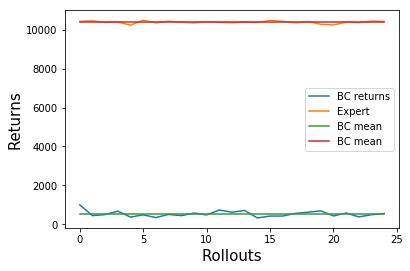

<Figure size 432x288 with 0 Axes>

In [61]:
# plot returns of BC and experts
plt.plot(returns, label = 'BC returns')
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [10438.186857983954, 10471.131848812303, 10389.244896091363, 10408.525369725054, 10249.73483750236, 10500.494293676069, 10365.63592228353, 10449.819812393624, 10399.94066843901, 10362.921788183248, 10427.754227585881, 10389.807021159531, 10375.111270627773, 10405.069458543141, 10381.935291587313, 10489.363191346045, 10440.62519389299, 10365.833474975829, 10430.640306509, 10295.54458154796, 10255.717391407743, 10405.162307972787, 10382.36730720193, 10454.536386206888, 10436.20845939734]
plt.plot(expert,label = 'Expert')
plt.plot(np.mean(returns)*np.ones((25,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((25,)), label = 'BC mean')
plt.legend()
plt.figure()
plt.show()

# DAgger

In [62]:
# define helper function for labeling
def label_data(game, data_pi):
    import tf_util
    policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
    action_list = []
    with tf.Session():
        tf_util.initialize()
        for idx, obs in enumerate(data_pi):
            action = policy_fn(obs[None,:])
            action_list.append(action)
    d_pi_action = np.array(action_list)
    return d_pi_action

# Define aggregation function
def aggregate(o1, a1, o2, a2):
    o = np.vstack((o1, o2))
    a = np.concatenate((a1, a2), axis = 0)
    
    # shuffle dataset
    n = o.shape[0]
    arr = np.arange(n)
    np.random.shuffle(arr)
    o, a = o[arr], a[arr]
    return o, a

obs (1, 376) (1, 376)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.8479734
val loss: 1.2419437 test loss:  1.2155992


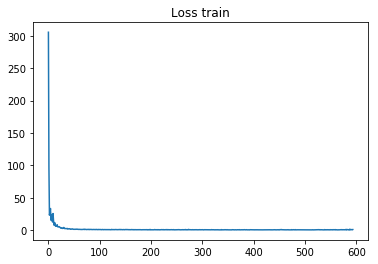


1 epoch: train loss 0.25215346
val loss: 0.39515382 test loss:  0.38538763

2 epoch: train loss 0.2665254
val loss: 0.27002883 test loss:  0.2678747

3 epoch: train loss 0.32304838
val loss: 0.23115312 test loss:  0.23304476

4 epoch: train loss 0.40680036
val loss: 0.20967293 test loss:  0.20905805

5 epoch: train loss 0.15369616
val loss: 0.19018911 test loss:  0.18861169

6 epoch: train loss 0.13463384
val loss: 0.15287566 test loss:  0.15147027

7 epoch: train loss 0.17768553
val loss: 0.13923179 test loss:  0.14002079

8 epoch: train loss 0.113629386
val loss: 0.1265538 test loss:  0.12732127


KeyboardInterrupt: 

In [63]:
# setup for DAgger
game = 'Humanoid-v2'
data = 'Humanoid-v2'
policy_fn = load_policy.load_policy('./experts/'+ str(game)+'.pkl')
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

seed, it_num, batch_size, epoch, num_rollouts = 1, 1e+5, 100, 25, 25
batch_size2  =  int(batch_size/3)
set_seed(seed)
sess = get_session()
env = gym.make(game)

# 1. train from human(expert) Data
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# 2. run trained policy to get dataset D_pi
returns, data_pi = eval_policy(game, num_rollouts, sess, state, out, env, data_gen = True, verbose = True)

# 3.ask human to label D_pi with action 
d_pi_action = label_data(game, data_pi)

# 4. aggregate two dataset
new_xt, new_yt = aggregate(x_train, y_train, data_pi, d_pi_action)

In [45]:
np.save('./expert_data/mixed/mixedHumanoid-v2action2.npy', new_yt)
np.save('./expert_data/mixed/mixedHumanoid-v2obs2.npy', new_xt)
# load dataset 5-0
new_yt = np.load('./expert_data/mixed/mixedHumanoid-v2action2.npy')
new_xt = np.load('./expert_data/mixed/mixedHumanoid-v2obs2.npy')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.5765229
val loss: 0.74221134 test loss:  0.727476


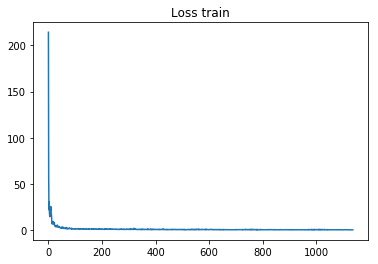


1 epoch: train loss 0.44373688
val loss: 0.14889304 test loss:  0.14701036

2 epoch: train loss 0.37125102
val loss: 0.120595105 test loss:  0.11896372

3 epoch: train loss 0.3252269
val loss: 0.10057897 test loss:  0.09943947

4 epoch: train loss 0.28611615
val loss: 0.08330285 test loss:  0.082856454

5 epoch: train loss 0.25646552
val loss: 0.07432927 test loss:  0.07403857

6 epoch: train loss 0.24588734
val loss: 0.064494476 test loss:  0.06399398

7 epoch: train loss 0.22180472
val loss: 0.05720345 test loss:  0.056854106

8 epoch: train loss 0.19509031
val loss: 0.051045068 test loss:  0.050918214

9 epoch: train loss 0.17656411
val loss: 0.04733962 test loss:  0.047194988

10 epoch: train loss 0.15937978
val loss: 0.04360283 test loss:  0.043297246


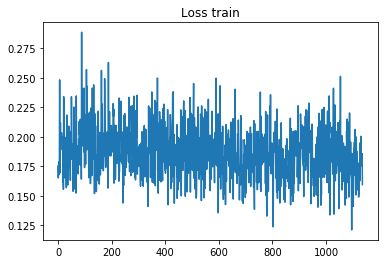


11 epoch: train loss 0.14028881
val loss: 0.04077757 test loss:  0.04044387

12 epoch: train loss 0.12959309
val loss: 0.0384813 test loss:  0.038211875

13 epoch: train loss 0.11904222
val loss: 0.036364954 test loss:  0.03637395

14 epoch: train loss 0.11219082
val loss: 0.034545388 test loss:  0.034241524

15 epoch: train loss 0.10678771
val loss: 0.032918315 test loss:  0.032702383

16 epoch: train loss 0.10117477
val loss: 0.031755757 test loss:  0.03152212

17 epoch: train loss 0.096835166
val loss: 0.030559616 test loss:  0.030359106

18 epoch: train loss 0.08921903
val loss: 0.029401312 test loss:  0.029246163

19 epoch: train loss 0.08522393
val loss: 0.02850511 test loss:  0.028274616

20 epoch: train loss 0.08043675
val loss: 0.027711516 test loss:  0.027549002


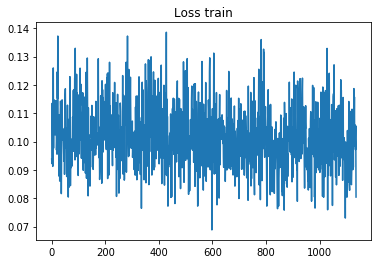


21 epoch: train loss 0.077500716
val loss: 0.026904525 test loss:  0.026768796

22 epoch: train loss 0.074102625
val loss: 0.026465328 test loss:  0.026275627

23 epoch: train loss 0.07170125
val loss: 0.025770614 test loss:  0.025566015

24 epoch: train loss 0.0679702
val loss: 0.024978565 test loss:  0.024903532

iter 0
mean return 3142.313982697937
std of return 0.0

iter 1
mean return 1817.6734197542878
std of return 1324.640562943649

iter 2
mean return 1714.124278986522
std of return 1091.4332762189038

iter 3
mean return 1714.857423773857
std of return 945.2097967288983

iter 4
mean return 1574.667343881659
std of return 890.7021285853938

iter 5
mean return 1362.6883616055986
std of return 941.169846267274

iter 6
mean return 1459.590734387632
std of return 903.104725051284

iter 7
mean return 1416.8427372606964
std of return 852.3145635076655

iter 8
mean return 1347.9276239547255
std of return 826.8729585318067

iter 9
mean return 1544.0023533977205
std of return 980.4869689

In [64]:
# 5. train nn with new dataset and check the performance
seed, it_num, batch_size, epoch, num_rollouts = 1, 1e+5, 100, 25, 25
batch_size2  =  int(batch_size/3)
set_seed(seed)
sess = get_session()
env = gym.make(game)

# 5-1. train from human(expert) Data
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, new_xt, new_yt, x_val, y_val, x_test, y_test)

# 5-2. run trained policy to get dataset D_pi
returns2 = eval_policy(game, 25, sess, state, out, env, data_gen = False, verbose = True)


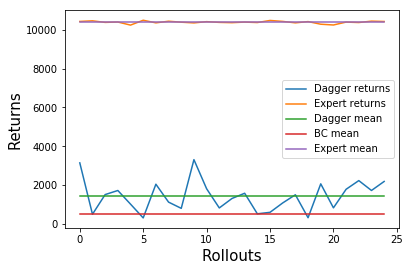

<Figure size 432x288 with 0 Axes>

In [67]:
# plot returns of BC and experts
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [10438.186857983954, 10471.131848812303, 10389.244896091363, 10408.525369725054, 10249.73483750236, 10500.494293676069, 10365.63592228353, 10449.819812393624, 10399.94066843901, 10362.921788183248, 10427.754227585881, 10389.807021159531, 10375.111270627773, 10405.069458543141, 10381.935291587313, 10489.363191346045, 10440.62519389299, 10365.833474975829, 10430.640306509, 10295.54458154796, 10255.717391407743, 10405.162307972787, 10382.36730720193, 10454.536386206888, 10436.20845939734]
plt.plot(returns2, label = 'Dagger returns')
plt.plot(expert,label = 'Expert returns')

plt.plot(np.mean(returns2)*np.ones((25,)), label = 'Dagger mean')
plt.plot(np.mean(returns)*np.ones((25,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((25,)), label = 'Expert mean')
plt.legend()
plt.figure()
plt.show()

# Bonus: BC with different network architecture 

In [68]:
# increase layer depth
def model(state_dim, action_dim):
    state = tf.placeholder(tf.float32, [None, state_dim])
    action = tf.placeholder(tf.float32, [None, 1, action_dim])
    if state_dim > 100:
        with tf.variable_scope('fc'):
            fc1 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(state, 1024))
            fc2 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc1, 1024))
            fc3 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc2, 1024))
            fc4 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc3, 1024))
            fc5 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc4, 512))
            fc6 = tf.layers.batch_normalization(tf.contrib.layers.fully_connected(fc5, 256))
            out = tf.contrib.layers.fully_connected(fc6, action_dim, activation_fn=None)   
    else:
        with tf.variable_scope('fc'):
            fc1 = tf.contrib.layers.fully_connected(state, 1024)
            out = tf.contrib.layers.fully_connected(fc1, action_dim, activation_fn=None)           
    
    out = tf.reshape(out, [tf.shape(state)[0], 1, action_dim])
    return state, action, out

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

0 epoch: train loss 0.16652042
val loss: 0.41565338 test loss:  0.39750162


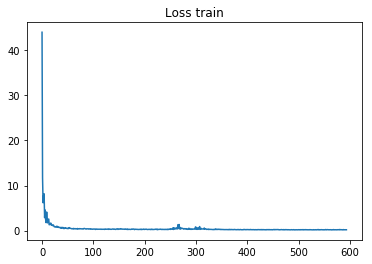


1 epoch: train loss 0.1262889
val loss: 0.15073112 test loss:  0.15026477

2 epoch: train loss 0.127388
val loss: 0.12030739 test loss:  0.12067899

3 epoch: train loss 0.10679226
val loss: 0.10602019 test loss:  0.106107086

4 epoch: train loss 0.09201822
val loss: 0.0950583 test loss:  0.0952561

5 epoch: train loss 0.08206045
val loss: 0.08918494 test loss:  0.08960585

6 epoch: train loss 0.07257975
val loss: 0.08241985 test loss:  0.08320927

7 epoch: train loss 0.06878947
val loss: 0.077712975 test loss:  0.07831547

8 epoch: train loss 0.06639698
val loss: 0.07439398 test loss:  0.075387485

9 epoch: train loss 0.06533434
val loss: 0.07178078 test loss:  0.07258503

10 epoch: train loss 0.059137307
val loss: 0.0687118 test loss:  0.06964379


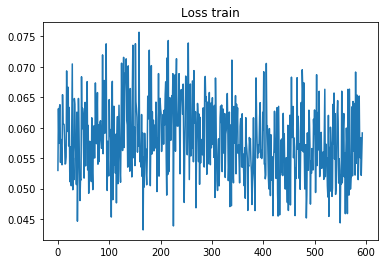


11 epoch: train loss 0.05566659
val loss: 0.06636559 test loss:  0.06710067

12 epoch: train loss 0.055991516
val loss: 0.064673506 test loss:  0.065236494

13 epoch: train loss 0.051454224
val loss: 0.0622802 test loss:  0.06292614

14 epoch: train loss 0.051241837
val loss: 0.060477775 test loss:  0.0612094

15 epoch: train loss 0.048392124
val loss: 0.059159476 test loss:  0.05968794

16 epoch: train loss 0.046950594
val loss: 0.057835184 test loss:  0.058231585

17 epoch: train loss 0.0447082
val loss: 0.056319136 test loss:  0.056990262

18 epoch: train loss 0.04322574
val loss: 0.05494207 test loss:  0.0555157

19 epoch: train loss 0.042251244
val loss: 0.05378648 test loss:  0.0542437

20 epoch: train loss 0.041778054
val loss: 0.052994724 test loss:  0.053517256


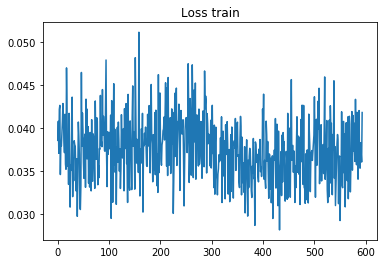


21 epoch: train loss 0.040037017
val loss: 0.052119516 test loss:  0.052615546

22 epoch: train loss 0.038660415
val loss: 0.051334422 test loss:  0.051906433

23 epoch: train loss 0.03903462
val loss: 0.050354153 test loss:  0.050685596

24 epoch: train loss 0.037255142
val loss: 0.049549058 test loss:  0.049926057
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

iter 0
mean return 393.0825580817108
std of return 0.0

iter 1
mean return 617.646057499677
std of return 224.56349941796628

iter 2
mean return 537.7159274433255
std of return 215.3992298706733

iter 3
mean return 477.0707438411524
std of return 214.0820778441839

iter 4
mean return 461.4311664541031
std of return 194.01879900321157

iter 5
mean return 449.0899914491387
std of return 179.251038978085

iter 6
mean return 460.5419368816254
std of return 168.30829965286117

iter 

In [69]:
# split data, create env
data = 'Humanoid-v2'
game = 'Humanoid-v2'
x_train, y_train, x_val, y_val, x_test, y_test, num_action, num_state = load_split_data(data, game)

# training deep neural nets
seed = 1
set_seed(seed)
sess = get_session()
it_num = int(1e+5)
batch_size = 100
batch_size2 = int(batch_size/3)
epoch = 25
sess, state, action, out = train_nn(seed, num_state, sess, num_action, it_num, batch_size, batch_size2, epoch, x_train, y_train, x_val, y_val, x_test, y_test)

# evaluate policy of trained agent
env = gym.make(game)
num_rollouts = 25
returns = []
returns = eval_policy(game, num_rollouts, sess, state, out, env)

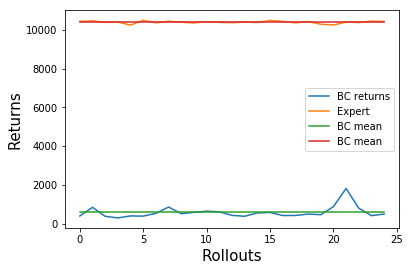

<Figure size 432x288 with 0 Axes>

In [71]:
# plot returns of BC and experts
plt.plot(returns, label = 'BC returns')
plt.xlabel('Rollouts', size=15)
plt.ylabel('Returns',size =15)
expert = [10438.186857983954, 10471.131848812303, 10389.244896091363, 10408.525369725054, 10249.73483750236, 10500.494293676069, 10365.63592228353, 10449.819812393624, 10399.94066843901, 10362.921788183248, 10427.754227585881, 10389.807021159531, 10375.111270627773, 10405.069458543141, 10381.935291587313, 10489.363191346045, 10440.62519389299, 10365.833474975829, 10430.640306509, 10295.54458154796, 10255.717391407743, 10405.162307972787, 10382.36730720193, 10454.536386206888, 10436.20845939734]
plt.plot(expert,label = 'Expert')
plt.plot(np.mean(returns)*np.ones((25,)), label = 'BC mean')
plt.plot(np.mean(expert)*np.ones((25,)), label = 'BC mean')
plt.legend()
plt.figure()
plt.show()